In [1]:
#Installing dependencies if you have not then pip install everything

import numpy as np
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import time
import tifffile as tif
import math
import raster_geometry as ras
import porespy as ps
from scipy.signal import general_gaussian, tukey
import jscatter as js 
import itertools


In [2]:

a=256 #boxsize, edge length of an image
onevoxel = 1 #how much in nm is one voxel (can be any unit but your q will depend on it)
radius=10 #radius of sphere
eta=1
params = [a,onevoxel,radius,eta]

def makingsphereimg2sas(params):
    a,onevoxel,radius,eta = params
    R = radius #also radius
    im = ras.sphere(a, radius/onevoxel, 0.5,smoothing=0) #creating sphere with raster geometry, notice radius/onevoxel
    im = im.astype('float32') #as float for ImageJ purposes
    im[im==0]=0 #electron density of surrounding the sphere can be solvent
    im[im==1]=eta #coloring the sphere with electron density
    return im
im_collection = []
params_collection = []
for i,j,k,l in itertools.product([50,100,150,200],[0.5,1,1.5,2,2.5],[5,10,15,20],[1,5,10,15]):
    params = i,j,k,l
    params_collection.append(params)
    im_collection.append(makingsphereimg2sas(params))
    


In [3]:
#window function just in case you need to taper the edge of your image
def window3d(w):
    # Convert a 1D filtering kernel to 3D
    # eg, window3D(numpy.hanning(5))
    L=w.shape[0]
    m1=np.outer(np.ravel(w), np.ravel(w))
    win1=np.tile(m1,np.hstack([L,1,1]))
    m2=np.outer(np.ravel(w),np.ones([1,L]))
    win2=np.tile(m2,np.hstack([L,1,1]))
    win2=np.transpose(win2,np.hstack([1,2,0]))
    win=np.multiply(win1,win2)
    return win




 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


(50, 1, 15, 5)

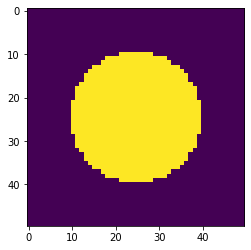

In [4]:
plt.imshow(im_collection[25][:,:,25])
print(im_collection[25][25,:,25])
params_collection[25]

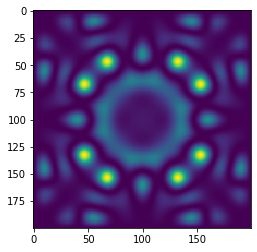

In [5]:
#below is the heart of IMG2SAS :)

def img2sas(im_win,params):
    a,onevoxel,radius,eta = params
    
    #fourier transform the 3d spectra
    spectrum_3d = np.fft.fftn(im_win)

    #shift the zero frequency to the center
    spectrum_3d_sh = np.fft.fftshift(spectrum_3d) 

    #fourier space intensity 
    intensity_3d = (spectrum_3d_sh.real)**2 + (spectrum_3d_sh.imag)**2

    plt.imshow(intensity_3d[:,:,2])

    #taking into account the shape of intensity 
    sx, sy, sz = intensity_3d.shape

    #creating a grid based on that
    X, Y, Z = np.ogrid[0:sx, 0:sy, 0:sz]

    #converting X Y Z to r in polar coordinates
    r = (np.sqrt(((X - sx/2)**2)+ ((Y - sy/2)**2)+ ((Z - sz/2)**2)))

    s=a/2

    rbin = np.around(s*np.sqrt(3)*(r)/(r.max()))

    #perform an average of intensity inside one bin and do it for all the bins
    radial_mean = ndimage.mean(intensity_3d, labels=rbin, index=np.arange(1, s+1))

    #making x axis corresponding to the reciprocal of real space
    x=np.arange(2*np.pi/(onevoxel*a),(np.pi/onevoxel)+(2*np.pi/(onevoxel*a)),2*np.pi/(onevoxel*a))
    
    radial_mean = radial_mean * ((np.sin(x*onevoxel/2)/(x*onevoxel/2))**2)
    return [radial_mean*(onevoxel**6),x]

radialmean_collection = []

for i in range(len(params_collection)):
    radialmean_collection.append(img2sas(im_collection[i],params_collection[i]))
                                 
                                 


In [6]:
#analytical form factor of sphere
# #K calculation
# Q=x
# K_prefactor = (4/3)*np.pi*(R**3)*eta*3;
# K_angle = (np.sin(Q*R) - R*Q*np.cos(Q*R))/((Q*R)**3);

# K = K_prefactor*K_angle;

# #Intensity 
# I = K**2;

In [7]:
#nice python package that includes form factor jscatter
analyticalff_collection = []

def formfactoranalytical(params,x):
    a,onevoxel,radius,eta = params
    return [js.ff.sphere(x,radius,eta).Y,js.ff.sphere(x,radius,eta).X]

for i in range(len(params_collection)):
    analyticalff_collection.append(formfactoranalytical(params_collection[i],radialmean_collection[i][1]))



In [8]:
analyticalff_collection[0]

[array([1.98420874e+05, 6.72599827e+04, 5.21047670e+03, 9.59420640e+02,
        1.58314349e+03, 2.55342998e+01, 3.16122470e+02, 1.36081269e+02,
        2.33053650e+01, 9.89464684e+01, 3.89967333e+00, 3.43133112e+01,
        2.07027026e+01, 3.39534063e+00, 1.95449814e+01, 1.03413842e+00,
        8.29027795e+00, 5.77920886e+00, 9.23981550e-01, 6.18415428e+00,
        3.79120462e-01, 2.91176791e+00, 2.19933258e+00, 3.45876278e-01,
        2.53302959e+00]),
 array([0.25132741, 0.50265482, 0.75398224, 1.00530965, 1.25663706,
        1.50796447, 1.75929189, 2.0106193 , 2.26194671, 2.51327412,
        2.76460154, 3.01592895, 3.26725636, 3.51858377, 3.76991118,
        4.0212386 , 4.27256601, 4.52389342, 4.77522083, 5.02654825,
        5.27787566, 5.52920307, 5.78053048, 6.03185789, 6.28318531])]

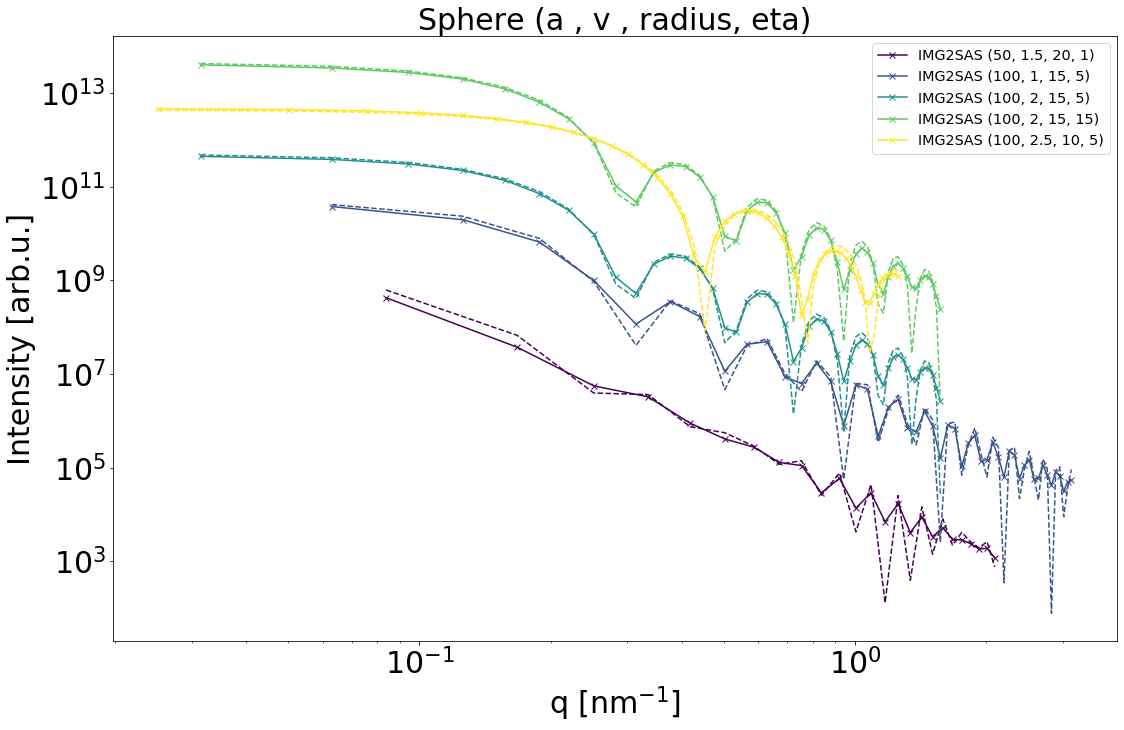

In [23]:
import matplotlib.pylab as pylab

params_plot = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 30,
         'axes.titlesize':30,
         'xtick.labelsize':30,
         'ytick.labelsize':30}
pylab.rcParams.update(params_plot)


fig = plt.figure()
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(222)
# ax3 = fig.add_subplot(223)
# ax4 = fig.add_subplot(224)
ax1.title.set_text('Sphere (a , v , radius, eta)')
# ax2.title.set_text('Second Plot')
# ax3.title.set_text('Third Plot')
# ax4.title.set_text('Fourth Plot')


width = 18
height = width / 1.618

#fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)

random_draw_param =np.random.randint(len(radialmean_collection), size=(5))
random_draw_param = np.sort(random_draw_param)

n=len(random_draw_param)

colors = plt.cm.viridis(np.linspace(0,1,n))

j = 0
for i in random_draw_param:
    plt.loglog(radialmean_collection[i][1],radialmean_collection[i][0]*(10**j),label='IMG2SAS '+str(params_collection[i]),marker='x',color=colors[j])
    plt.loglog(analyticalff_collection[i][1],analyticalff_collection[i][0]*(10**j),'--',color=colors[j])
    j+=1




#ax1.set_ylim((float(10**-1),float(10**8)))
ax1.set_ylabel('Intensity [arb.u.]')
ax1.set_xlabel('q [nm$^{-1}$]')



plt.legend()

fig.set_size_inches(width, height)

plt.show()

fig.savefig('plotspherenice.png',dpi=300)


In [10]:
random_draw_param

array([ 48,  74, 118, 119, 124, 147, 179, 202, 297, 317])